In [1]:
# Instalo las dependencias necesarias
!pip install sqlalchemy psycopg2 pandas matplotlib dotenv seaborn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Importo las librerías
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd
from db_conector import get_db_engine
from modelos import Usuario, DetalleOrden, Orden, Producto, Categoria, HistorialPago

Conectando a: admin:dept01@localhost:5432/EcommerceDB
Conexion creada exitosamente.


In [ ]:
# Muestro la tabla de usuarios
engine = get_db_engine()
session = Session(engine)

try:
    usuarios_query = session.query(Usuario).all()
    df_usuarios = pd.DataFrame([
        {
            'usuarioid': u.usuarioid,
            'nombre': u.nombre,
            'apellido': u.apellido,
            'dni': u.dni,
            'email': u.email,
            'fecharegistro': u.fecharegistro
        } for u in usuarios_query
    ])
    display(df_usuarios.head())
except Exception as e:
    print(f"Error tabla usuarios: {e}")
    session.rollback()
finally:
    session.close()

,usuarioid,nombre,apellido,dni,email,fecharegistro
0,1,Encarna,Donaire,49877134,encarna.donaire1@correo.com,2025-07-15 13:08:55.827943
1,2,Jose Ignacio,Canales,98778810,jose ignacio.canales2@correo.com,2025-07-15 13:08:55.827943
2,3,José,Sebastián,80095714,josé.sebastián3@correo.com,2025-07-15 13:08:55.827943
3,4,Priscila,Vilar,94128750,priscila.vilar4@correo.com,2025-07-15 13:08:55.827943
4,5,Epifanio,Ríos,62958342,epifanio.ríos5@correo.com,2025-07-15 13:08:55.827943


✅ Total de usuarios únicos: 1000


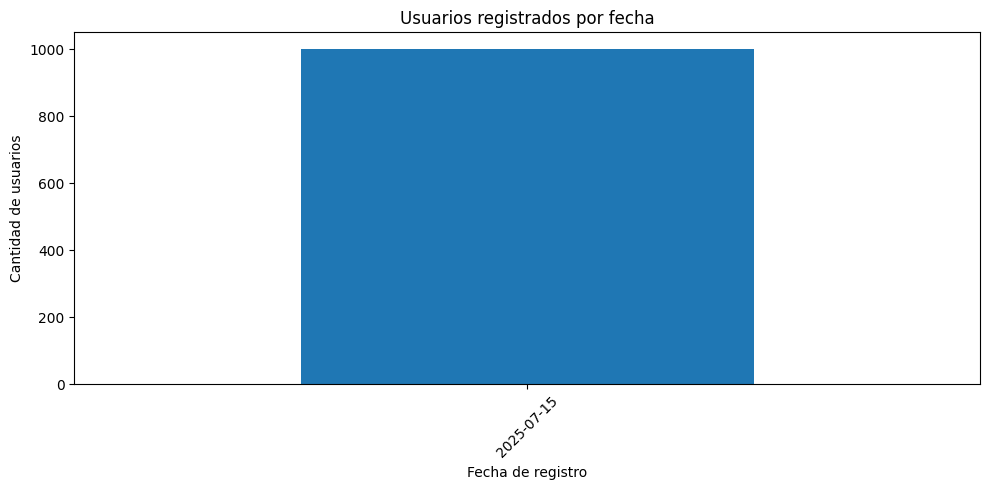

In [ ]:
# Grafico de usuarios por fecha de registro

engine = get_db_engine()
session = Session(engine)

try:
    usuarios_query = session.query(Usuario).all()
    df_usuarios = pd.DataFrame([
        {
            'usuarioid': u.usuarioid,
            'fecharegistro': u.fecharegistro
        } for u in usuarios_query
    ])

    df_usuarios['fecharegistro'] = pd.to_datetime(df_usuarios['fecharegistro'])
    cantidad_unicos = df_usuarios['usuarioid'].nunique()
    print(f"✅ Total de usuarios únicos: {cantidad_unicos}")

    registros_por_fecha = df_usuarios.groupby(df_usuarios['fecharegistro'].dt.date).count()

    # Creo grafico de barras 
    plt.figure(figsize=(10, 5))
    registros_por_fecha['usuarioid'].plot(kind='bar')
    plt.title("Usuarios registrados por fecha")
    plt.xlabel("Fecha de registro")
    plt.ylabel("Cantidad de usuarios")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error tabla usuarios: {e}")
    session.rollback()
finally:
    session.close()


✅ Total de productos: 36
                     categoria  cantidad
0                  Electrónica         3
1                         Moda         3
2               Hogar y Cocina         3
3        Deportes y Aire Libre         3
4   Belleza y Cuidado Personal         3
5            Juguetes y Juegos         3
6                   Automotriz         3
7           Libros y Papelería         3
8                        Salud         3
9                     Mascotas         3
10        Tecnología y Gadgets         3
11                 Videojuegos         3


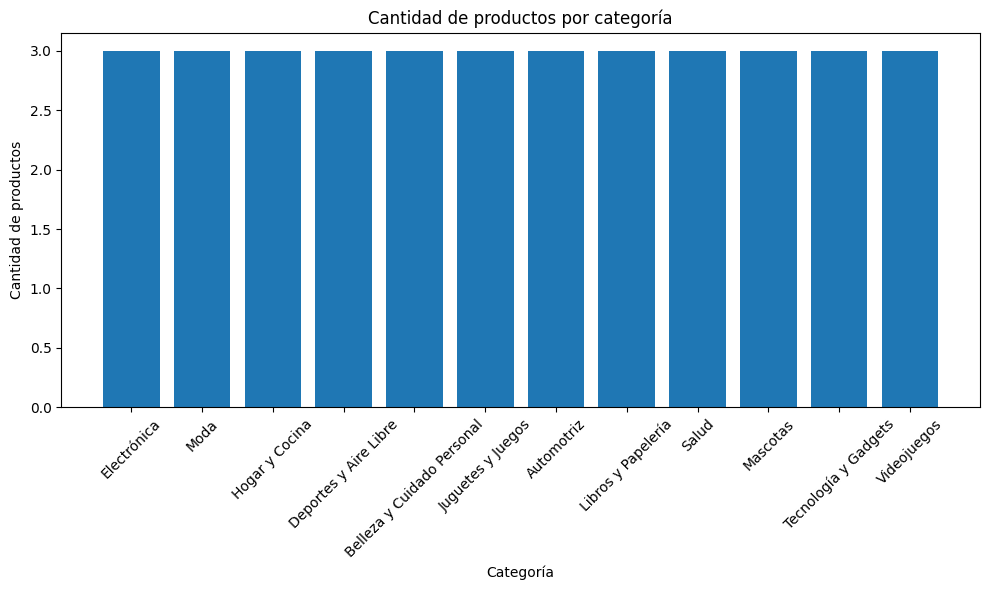

In [ ]:
# Controlo los productos por categoría

engine = get_db_engine()
session = Session(engine)

try:
    productos_query = session.query(Producto).join(Categoria).all()

    df_productos = pd.DataFrame([
        {
            'producto_id': p.productoid,
            'producto_nombre': p.nombre,
            'categoria_nombre': p.categoria.nombre if p.categoria else 'Sin categoría'
        } for p in productos_query
    ])

    conteo = df_productos['categoria_nombre'].value_counts().reset_index()
    conteo.columns = ['categoria', 'cantidad']
    print(f"✅ Total de productos: {df_productos['producto_id'].nunique()}")
    print(conteo)

    # Creo el gráfico de barras con los productos por categoría
    plt.figure(figsize=(10, 6))
    plt.bar(conteo['categoria'], conteo['cantidad'])
    plt.title("Cantidad de productos por categoría")
    plt.xlabel("Categoría")
    plt.ylabel("Cantidad de productos")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error tabla productos: {e}")
    session.rollback()
finally:
    session.close()

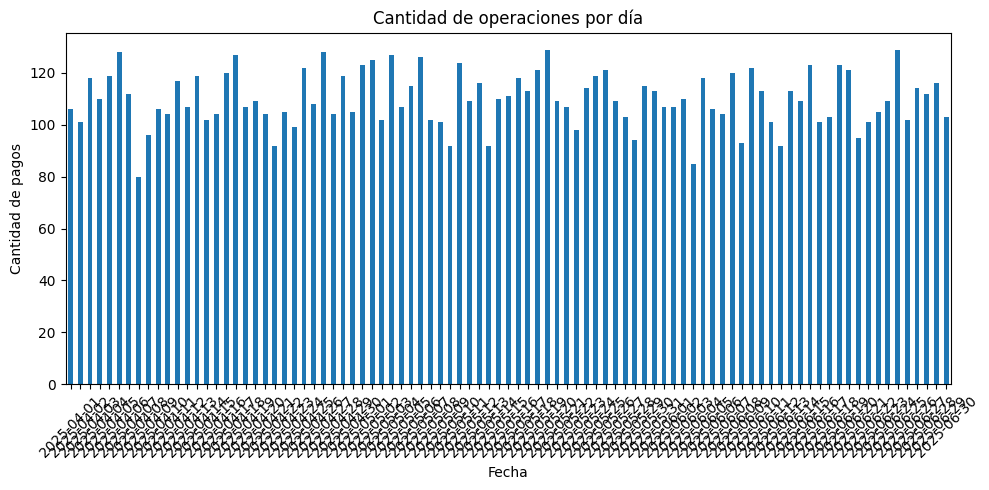

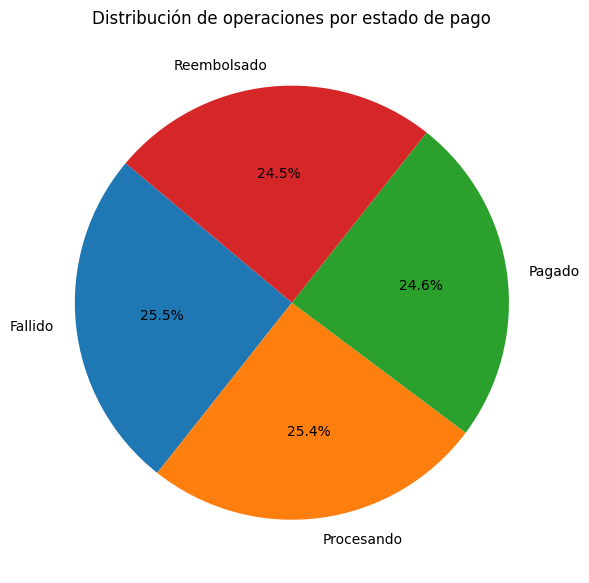

In [ ]:
# Muestro la tabla de historial de pagos

engine = get_db_engine()
session = Session(engine)

try:
    pagos_query = session.query(HistorialPago).all()

    # Crear DataFrame
    df_pagos = pd.DataFrame([
        {
            'id': p.pagoid,
            'fecha_pago': p.fecha_pago,
            'estado_pago': p.estado_pago
        } for p in pagos_query
    ])

    df_pagos['fecha_pago'] = pd.to_datetime(df_pagos['fecha_pago'])

    #  Gráfico de barras con las operaciones por día
    pagos_por_dia = df_pagos.groupby(df_pagos['fecha_pago'].dt.date).count()

    plt.figure(figsize=(10, 5))
    pagos_por_dia['id'].plot(kind='bar')
    plt.title("Cantidad de operaciones por día")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad de pagos")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico de torta diferentes estado_pago
    estado_counts = df_pagos['estado_pago'].value_counts()

    plt.figure(figsize=(6, 6))
    plt.pie(estado_counts, labels=estado_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title("Distribución de operaciones por estado de pago")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


except Exception as e:
    print(f"Error tabla historial_pagos: {e}")
    session.rollback()
finally:
    session.close()


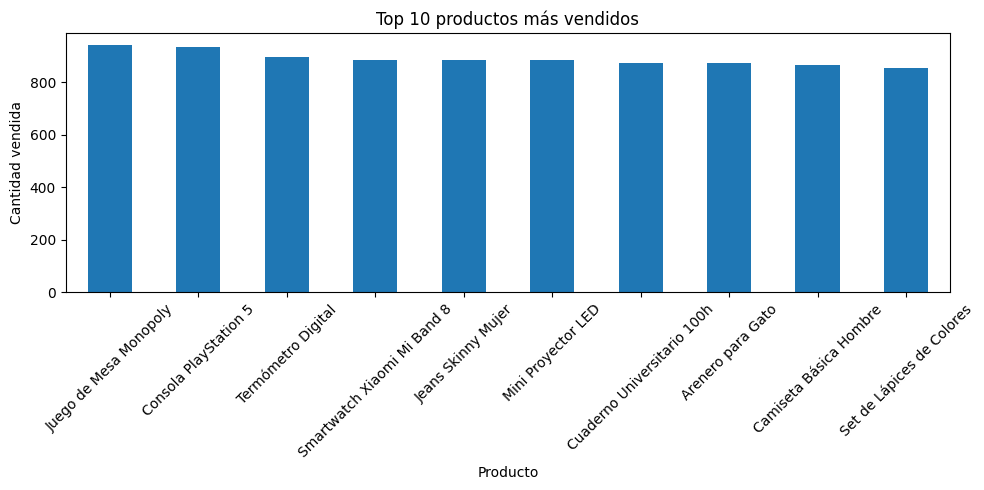

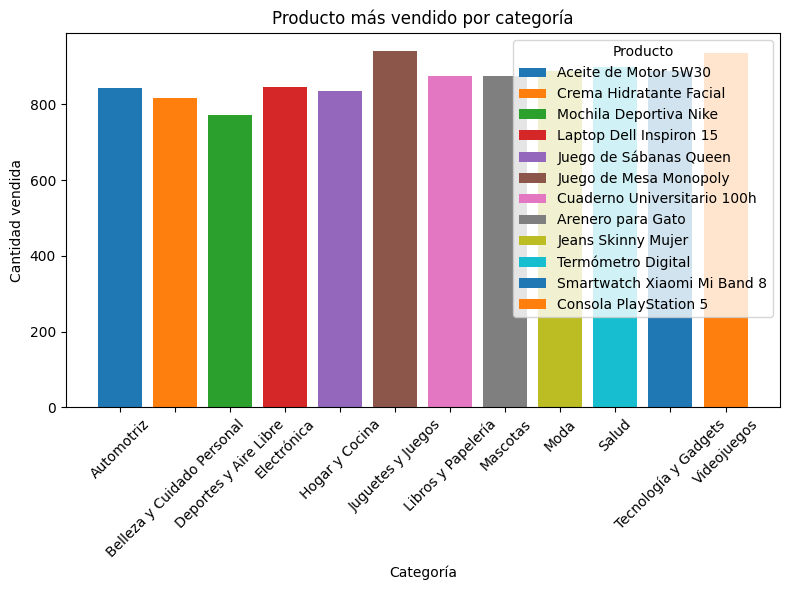

In [ ]:
# Muestro los 10 productos más vendidos y los productos más vendidos por categoría

engine = get_db_engine()
session = Session(engine)

try:
    detalles_query = session.query(
        Producto.productoid,
        Producto.nombre.label("producto_nombre"),
        Categoria.nombre.label("categoria_nombre"),
        DetalleOrden.cantidad
    ).join(Producto.detalles).join(Producto.categoria).all()

    df = pd.DataFrame(detalles_query, columns=['productoid', 'producto_nombre', 'categoria_nombre', 'cantidad'])

    # --- Gráfico de los 10 Productos más vendidos
    top_productos = df.groupby('producto_nombre')['cantidad'].sum().sort_values(ascending=False).head(10)

    plt.figure(figsize=(10, 5))
    top_productos.plot(kind='bar')
    plt.title("Top 10 productos más vendidos")
    plt.xlabel("Producto")
    plt.ylabel("Cantidad vendida")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Gráfico de Productos más vendidos por categoría
    productos_categoria = df.groupby(['categoria_nombre', 'producto_nombre'])['cantidad'].sum().reset_index()
    top_por_categoria = productos_categoria.sort_values(['categoria_nombre', 'cantidad'], ascending=[True, False]) \
                                           .groupby('categoria_nombre').head(1)

    plt.figure(figsize=(8, 6))
    for i, row in top_por_categoria.iterrows():
        plt.bar(row['categoria_nombre'], row['cantidad'], label=row['producto_nombre'])

    plt.title("Producto más vendido por categoría")
    plt.xlabel("Categoría")
    plt.ylabel("Cantidad vendida")
    plt.xticks(rotation=45)
    plt.legend(title="Producto")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error tabla de productos: {e}")
    session.rollback()
finally:
    session.close()
